In [1]:

import numpy as np
import pandas as pd
import numba as nb

from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from IPython.display import clear_output



In [2]:

df_train = pd.read_csv('./input/train/sign_mnist_train.csv')
df_test = pd.read_csv('./input/test/sign_mnist_test.csv')




In [3]:

# only hand gestures from 0 to 10, X represents all the pixels (from  col 1 to 1784)
X_train, y_train = df_train[df_train['label'] < 10].values[:,1:], df_train[df_train['label'] < 10].values[:,0]
X_test, y_test = df_test[df_test['label'] < 10].values[:,1:], df_test[df_test['label'] < 10].values[:,0]



In [5]:


# Normalize
X_train, X_test = X_train / 255., X_test / 255

# Format (#, 1, 28, 28)
X_train, X_test = X_train.reshape(X_train.shape[0], 1, 28, 28), X_test.reshape(X_test.shape[0], 1, 28, 28)



In [19]:


@nb.jit(nopython=True)
def maxpool(X, f, s):
    (l, w, w) = X.shape
    pool = np.zeros((l, (w-f)//s+1,(w-f)//s+1))
    for jj in range(0,l):
        for i in range(0, w, s):
            for j in range(0, w, s):
                pool[jj,i//2,j//2] = np.max(X[jj,i:i+f,j:j+f])
    return pool




@nb.jit(nopython=True)
def relu(x):
    return x * (x > 0)

@nb.jit(nopython=True)
def drelu(x):
    return 1. * (x > 0)


def softmax_cost(out,y):
    eout = np.exp(out, dtype=np.float)
    probs = eout/sum(eout)

    p = sum(y*probs)
    cost = -np.log(p)
    return cost, probs





In [20]:
@nb.jit(nopython=True)
def forward(image, theta, sizes):
    filt1, filt2, bias1, bias2, theta3, bias3 = theta
    l, w, f, l1, l2, w1, w2 = sizes

    conv1 = np.zeros((l1,w1,w1))
    conv2 = np.zeros((l2,w2,w2))

    for jj in range(0,l1):
        for x in range(0,w1):
            for y in range(0,w1):
                conv1[jj,x,y] = np.sum(image[:,x:x+f,y:y+f]*filt1[jj])+bias1[jj]
    conv1 = relu(conv1)

    for jj in range(0,l2):
        for x in range(0,w2):
            for y in range(0,w2):
                conv2[jj,x,y] = np.sum(conv1[:,x:x+f,y:y+f]*filt2[jj])+bias2[jj]
    conv2 = relu(conv2)

    ## Pooled layer with 2*2 size and stride 2,2
    pooled_layer = maxpool(conv2, 2, 2)	

    fc1 = pooled_layer.reshape(((w2//2)*(w2//2)*l2,1))

    out = theta3.dot(fc1) + bias3

    return conv1, conv2, pooled_layer, fc1, out

In [21]:
# get the highest (index) value of the arrays
def get_nanargmax(conv2, sizes):

    def nanargmax(a):
        idx = np.argmax(a, axis=None)
        multi_idx = np.unravel_index(idx, a.shape)
        if np.isnan(a[multi_idx]):
            nan_count = np.sum(np.isnan(a))
            idx = np.argpartition(a, -nan_count-1, axis=None)[-nan_count-1]
            multi_idx = np.unravel_index(idx, a.shape)
        return multi_idx

    l, w, f, l1, l2, w1, w2 = sizes
    nanarg = np.zeros((l2, w2, w2, 2))

    for jj in range(0, l2):
        for i in range(0, w2, 2):
            for j in range(0, w2, 2):
                (a,b) = nanargmax(conv2[jj,i:i+2,j:j+2])
                nanarg[jj, i, j, 0] = a
                nanarg[jj, i, j, 1] = b

    return nanarg

In [22]:


@nb.jit(nopython=True)
def init_grads(sizes):
    l, w, f, l1, l2, w1, w2 = sizes
    
    dconv2 = np.zeros((l2, w2, w2))
    dconv1 = np.zeros((l1, w1, w1))

    dfilt2 = np.zeros((l2, l1,f,f))
    dbias2 = np.zeros((l2, ))

    dfilt1 = np.zeros((l1,l,f,f))
    dbias1 = np.zeros((l1,))
    
    return dconv1, dconv2, dfilt1, dfilt2, dbias1, dbias2



In [24]:
@nb.jit(nopython=True)
def backward(image, label, theta, delta, probs, nanarg, sizes):
    l, w, f, l1, l2, w1, w2 = sizes
    conv1, conv2, pooled_layer, fc1, out = delta
    dconv1, dconv2, dfilt1, dfilt2, dbias1, dbias2 = init_grads(sizes)

    dout = probs - label
    dtheta3 = dout.dot(fc1.T)
    dbias3 = dout

    dfc1 = dtheta3.T.dot(dout)
    dpool = dfc1.T.reshape((l2, w2//2, w2//2))

    for jj in range(0, l2):
        for i in range(0, w2, 2):
            for j in range(0, w2, 2):
                a = int(nanarg[jj , i, j, 0])
                b = int(nanarg[jj , i, j, 1])
                dconv2[jj,i+a,j+b] = dpool[jj,i//2,j//2]

    dconv2 = dconv2 * drelu(conv2)

    for jj in range(0,l2):
        for x in range(0,w2):
            for y in range(0,w2):
                dfilt2[jj]+=dconv2[jj,x,y]*conv1[:,x:x+f,y:y+f]
                dconv1[:,x:x+f,y:y+f]+=dconv2[jj,x,y]*filt2[jj]
        dbias2[jj] = np.sum(dconv2[jj])

    dconv1 = dconv1 * drelu(conv1)

    for jj in range(0,l1):
        for x in range(0,w1):
            for y in range(0,w1):
                dfilt1[jj]+=dconv1[jj,x,y]*image[:,x:x+f,y:y+f]

        dbias1[jj] = np.sum(dconv1[jj])

    return dfilt1, dfilt2, dbias1, dbias2, dtheta3, dbias3

In [25]:
def init_grads_velocity(filt1, filt2, bias1, bias2, theta3, bias3):
    dfilt1 = np.zeros((len(filt1), filt1[0].shape[0], filt1[0].shape[1], filt1[0].shape[2]))
    dbias1 = np.zeros((len(filt1),))
    v1 = np.zeros((len(filt1), filt1[0].shape[0], filt1[0].shape[1], filt1[0].shape[2]))
    bv1 = np.zeros((len(filt1),))

    dfilt2 = np.zeros((len(filt2), filt2[0].shape[0], filt2[0].shape[1], filt2[0].shape[2]))
    dbias2 = np.zeros((len(filt2),))
    v2 = np.zeros((len(filt2), filt2[0].shape[0], filt2[0].shape[1], filt2[0].shape[2]))
    bv2 = np.zeros((len(filt2),))

    dtheta3 = np.zeros(theta3.shape)
    dbias3 = np.zeros(bias3.shape)
    v3 = np.zeros(theta3.shape)
    bv3 = np.zeros(bias3.shape)

    return dfilt1, dfilt2, dtheta3, dbias1, dbias2, dbias3, v1, v2, v3, bv1, bv2, bv3



def batches(X, y, size):
    batches = []
    
    for idx in np.array_split(np.arange(len(X)), len(X) / size):
        X_batch = X[idx]
        y_batch = y[idx]
        batches.append((X_batch, y_batch))
    
    return batches


In [32]:


NUM_OUTPUT = 10
LEARNING_RATE = 0.0001
IMG_WIDTH = 28
IMG_DEPTH = 1
FILTER_SIZE=5
NUM_FILT1 = 8
NUM_FILT2 = 8
BATCH_SIZE = 8
NUM_EPOCHS = 3000
MU = 0.95
NUM_IMAGES = int(len(X_train) / BATCH_SIZE)


# @nb.jit(nopython=True)
# def _initGrads(sizes):
#     """Initialize gradient arrays."""
#     l, w, f, l1, l2, w1, w2 = sizes
    
#     dconv2 = np.zeros((l2, w2, w2))
#     dconv1 = np.zeros((l1, w1, w1))
    
#     dfilt2 = np.zeros((l2, l1, f, f))
#     dbias2 = np.zeros((l2,))
    
#     dfilt1 = np.zeros((l1, l, f, f))
#     dbias1 = np.zeros((l1,))
    
#     return dconv1, dconv2, dfilt1, dfilt2, dbias1, dbias2

# @nb.jit(nopython=True)
# def _backward(image, label, filt1, filt2, theta3, delta, probs, nanarg, sizes):
#     """Backward propagation to compute gradients."""
#     l, w, f, l1, l2, w1, w2 = sizes
#     conv1, conv2, pooled_layer, fc1, out = delta
#     dconv1, dconv2, dfilt1, dfilt2, dbias1, dbias2 = _initGrads(sizes)
    
#     # Output layer gradients
#     dout = probs - label
#     dtheta3 = dout.dot(fc1.T)
#     dbias3 = dout
    
#     # Fully connected layer gradients
#     dfc1 = theta3.T.dot(dout)
#     dpool = dfc1.T.reshape((l2, w2//2, w2//2))
    
#     # Max pooling backward pass
#     for jj in range(0, l2):
#         for i in range(0, w2, 2):
#             for j in range(0, w2, 2):
#                 a = int(nanarg[jj, i, j, 0])
#                 b = int(nanarg[jj, i, j, 1])
#                 dconv2[jj, i+a, j+b] = dpool[jj, i//2, j//2]
    
#     dconv2 = dconv2 * _drelu(conv2)
    
#     # Second convolutional layer gradients
#     for jj in range(0, l2):
#         for x in range(0, w2):
#             for y in range(0, w2):
#                 dfilt2[jj] += dconv2[jj, x, y] * conv1[:, x:x+f, y:y+f]
#                 dconv1[:, x:x+f, y:y+f] += dconv2[jj, x, y] * filt2[jj]
#         dbias2[jj] = np.sum(dconv2[jj])
    
#     dconv1 = dconv1 * _drelu(conv1)
    
#     # First convolutional layer gradients
#     for jj in range(0, l1):
#         for x in range(0, w1):
#             for y in range(0, w1):
#                 dfilt1[jj] += dconv1[jj, x, y] * image[:, x:x+f, y:y+f]
#         dbias1[jj] = np.sum(dconv1[jj])
    
#     return dfilt1, dfilt2, dbias1, dbias2, dtheta3, dbias3


# @nb.jit(nopython=True)
# def _maxPool(X, f, s):
#     """Max pooling operation."""
#     (l, w, w) = X.shape
#     pool = np.zeros((l, (w-f)//s+1, (w-f)//s+1))
#     for jj in range(0, l):
#         for i in range(0, w, s):
#             for j in range(0, w, s):
#                 pool[jj, i//2, j//2] = np.max(X[jj, i:i+f, j:j+f])
#     return pool

# @nb.jit(nopython=True)
# def _relu(x):
#     """ReLU activation function."""
#     return x * (x > 0)

# @nb.jit(nopython=True)
# def _drelu(x):
#     """Derivative of ReLU activation function."""
#     return 1. * (x > 0)



np.random.seed(3424242)

scale = 1.0
stddev = scale * np.sqrt(1./FILTER_SIZE*FILTER_SIZE*IMG_DEPTH)

filt1 =np.random.normal(loc = 0, scale=stddev, size=((NUM_FILT1,IMG_DEPTH,FILTER_SIZE,FILTER_SIZE)))
bias1 = np.zeros((NUM_FILT1,))
filt2 =np.random.normal(loc = 0, scale=stddev, size=((NUM_FILT2,NUM_FILT1,FILTER_SIZE,FILTER_SIZE)))
bias2 = np.zeros((NUM_FILT2,))

w1 = IMG_WIDTH-FILTER_SIZE+1
w2 = w1-FILTER_SIZE+1

theta3 = np.random.rand(NUM_OUTPUT, (w2//2)*(w2//2)*NUM_FILT2) * 0.01
bias3 = np.zeros((NUM_OUTPUT,1))

theta = filt1, filt2, bias1, bias2, theta3, bias3



(l,w,w) = X_train[0].shape
(l1,f,f) = filt2[0].shape
l2 = len(filt2)
w1 = w-f+1
w2 = w1-f+1

sizes = l, w, f, l1, l2, w1, w2





accuracies = []
costs = []





for epoch in range(NUM_EPOCHS):

    print(f"Epoch {epoch}")

    filt1, filt2, bias1, bias2, theta3, bias3 = theta
    dfilt1, dfilt2, dtheta3, dbias1, dbias2, dbias3, v1, v2, v3, bv1, bv2, bv3 = init_grads_velocity(filt1, filt2, bias1, bias2, theta3, bias3)
    
    X_train, y_train = shuffle(X_train, y_train, random_state=0)
    minibatches = batches(X_train, y_train, BATCH_SIZE)
    
    idx = np.random.randint(0, len(minibatches))
    X_batch, y_batch = minibatches[idx]

    acc = 0
    cost_epoch = 0

    for i in range(0, BATCH_SIZE):

        label = np.zeros((theta3.shape[0],1))
        label[int(y_batch[i]),0] = 1

        delta = forward(X_batch[i], theta, sizes)

        cost, probs = softmax_cost(delta[-1], label)
        if np.argmax(probs) == np.argmax(label):
            acc += 1
        cost_epoch += cost
            
        nanarg = get_nanargmax(delta[1], sizes)
        dfilt1, dfilt2, dbias1, dbias2, dtheta3, dbias3 = backward(X_batch[i], label, theta, delta, probs, nanarg, sizes)

        dfilt2 += dfilt2
        dbias2 += dbias2

        dfilt1 += dfilt1
        dbias1 += dbias1

        dtheta3 += dtheta3
        dbias3 += dbias3
        
    accuracies.append(acc)
    costs.append(cost_epoch/BATCH_SIZE)

    v1 = MU * v1 - LEARNING_RATE * dfilt1 / BATCH_SIZE
    filt1 += v1
    bv1 = MU * bv1 - LEARNING_RATE * dbias1 / BATCH_SIZE
    bias1 += bv1

    v2 = MU * v2 - LEARNING_RATE * dfilt2 / BATCH_SIZE
    filt2 += v2
    bv2 = MU * bv2 - LEARNING_RATE * dbias2 / BATCH_SIZE
    bias2 += bv2

    v3 = MU * v3 - LEARNING_RATE * dtheta3 / BATCH_SIZE
    theta3 += v3
    bv3 = MU * bv3 - LEARNING_RATE * dbias3 / BATCH_SIZE
    bias3 += bv3

    theta = filt1, filt2, bias1, bias2, theta3, bias3

    # if(epoch % 150 == 0):
    #     print("Epoch:{0:3d}, Accuracy:{1:0.3f}, Cost:{2:3.3f}".format(epoch, acc/BATCH_SIZE, costs[-1][0]))




SystemError: CPUDispatcher(<function forward at 0x7f1244876160>) returned a result with an exception set

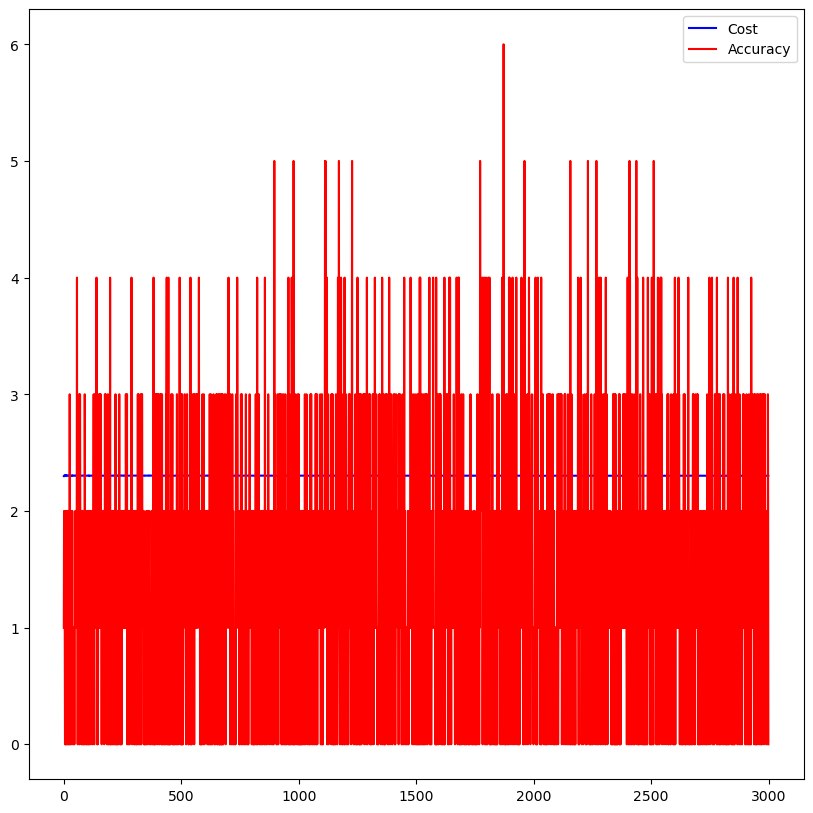

In [27]:
costs = np.array(costs)
accuracies = np.array(accuracies)

plt.figure(figsize=(10,10))
plt.plot(costs, "-b", label="Cost")
plt.plot(accuracies, "-r", label="Accuracy")
plt.legend(loc="upper right")
plt.show()






In [28]:
def accuracy(X_test, y_test):
    acc = 0
    for i in range(len(X_test)):
        delta = forward(X_test[i], theta, sizes)
        cost, probs = softmax_cost(delta[-1], label)
        
        if np.argmax(probs) == y_test[i]:
            acc += 1
    print("Test accuracy:{0:2.2f}%".format(acc/len(X_test) * 100))


accuracy(X_test, y_test)

Test accuracy:16.20%


In [29]:
import numpy as np
import pandas as pd
import numba as nb



@nb.jit(nopython=True)
def _initGrads(sizes):
    """Initialize gradient arrays."""
    l, w, f, l1, l2, w1, w2 = sizes
    
    dconv2 = np.zeros((l2, w2, w2))
    dconv1 = np.zeros((l1, w1, w1))
    
    dfilt2 = np.zeros((l2, l1, f, f))
    dbias2 = np.zeros((l2,))
    
    dfilt1 = np.zeros((l1, l, f, f))
    dbias1 = np.zeros((l1,))
    
    return dconv1, dconv2, dfilt1, dfilt2, dbias1, dbias2

@nb.jit(nopython=True)
def _backward(image, label, filt1, filt2, theta3, delta, probs, nanarg, sizes):
    """Backward propagation to compute gradients."""
    l, w, f, l1, l2, w1, w2 = sizes
    conv1, conv2, pooled_layer, fc1, out = delta
    dconv1, dconv2, dfilt1, dfilt2, dbias1, dbias2 = _initGrads(sizes)
    
    # Output layer gradients
    dout = probs - label
    dtheta3 = dout.dot(fc1.T)
    dbias3 = dout
    
    # Fully connected layer gradients
    dfc1 = theta3.T.dot(dout)
    dpool = dfc1.T.reshape((l2, w2//2, w2//2))
    
    # Max pooling backward pass
    for jj in range(0, l2):
        for i in range(0, w2, 2):
            for j in range(0, w2, 2):
                a = int(nanarg[jj, i, j, 0])
                b = int(nanarg[jj, i, j, 1])
                dconv2[jj, i+a, j+b] = dpool[jj, i//2, j//2]
    
    dconv2 = dconv2 * _drelu(conv2)
    
    # Second convolutional layer gradients
    for jj in range(0, l2):
        for x in range(0, w2):
            for y in range(0, w2):
                dfilt2[jj] += dconv2[jj, x, y] * conv1[:, x:x+f, y:y+f]
                dconv1[:, x:x+f, y:y+f] += dconv2[jj, x, y] * filt2[jj]
        dbias2[jj] = np.sum(dconv2[jj])
    
    dconv1 = dconv1 * _drelu(conv1)
    
    # First convolutional layer gradients
    for jj in range(0, l1):
        for x in range(0, w1):
            for y in range(0, w1):
                dfilt1[jj] += dconv1[jj, x, y] * image[:, x:x+f, y:y+f]
        dbias1[jj] = np.sum(dconv1[jj])
    
    return dfilt1, dfilt2, dbias1, dbias2, dtheta3, dbias3


@nb.jit(nopython=True)
def _maxPool(X, f, s):
    """Max pooling operation."""
    (l, w, w) = X.shape
    pool = np.zeros((l, (w-f)//s+1, (w-f)//s+1))
    for jj in range(0, l):
        for i in range(0, w, s):
            for j in range(0, w, s):
                pool[jj, i//2, j//2] = np.max(X[jj, i:i+f, j:j+f])
    return pool

@nb.jit(nopython=True)
def _relu(x):
    """ReLU activation function."""
    return x * (x > 0)

@nb.jit(nopython=True)
def _drelu(x):
    """Derivative of ReLU activation function."""
    return 1. * (x > 0)


@nb.jit(nopython=True)
def _forward(image, filt1, filt2, bias1, bias2, theta3, bias3, sizes):
    """Forward propagation through the network."""
    l, w, f, l1, l2, w1, w2 = sizes
    
    conv1 = np.zeros((l1, w1, w1))
    conv2 = np.zeros((l2, w2, w2))
    
    # First convolutional layer
    for jj in range(0, l1):
        for x in range(0, w1):
            for y in range(0, w1):
                conv1[jj, x, y] = np.sum(image[:, x:x+f, y:y+f] * filt1[jj]) + bias1[jj]
    conv1 = _relu(conv1)
    
    # Second convolutional layer
    for jj in range(0, l2):
        for x in range(0, w2):
            for y in range(0, w2):
                conv2[jj, x, y] = np.sum(conv1[:, x:x+f, y:y+f] * filt2[jj]) + bias2[jj]
    conv2 = _relu(conv2)
    
    # Max pooling
    pooled_layer = _maxPool(conv2, 2, 2)
    
    # Fully connected layer
    fc1 = pooled_layer.reshape(((w2//2) * (w2//2) * l2, 1))
    out = theta3.dot(fc1) + bias3
    
    return conv1, conv2, pooled_layer, fc1, out


class CNN:
    def __init__(self, num_output=10, learning_rate=0.0001, img_width=28, img_depth=1, 
                 filter_size=5, num_filt1=8, num_filt2=8, momentum=0.95):
        """
        Initialize CNN with specified architecture parameters.
        """
        self.num_output = num_output
        self.learning_rate = learning_rate
        self.img_width = img_width
        self.img_depth = img_depth
        self.filter_size = filter_size
        self.num_filt1 = num_filt1
        self.num_filt2 = num_filt2
        self.momentum = momentum
        
        # Calculate dimensions
        self.w1 = img_width - filter_size + 1  # After first conv
        self.w2 = self.w1 - filter_size + 1    # After second conv
        
        # Initialize network parameters
        self._initializeParameters()
        
        # Initialize momentum terms
        self._initializeMomentum()
        
        # Set up sizes tuple for numba functions
        self.sizes = (img_depth, img_width, filter_size, num_filt1, num_filt2, self.w1, self.w2)

    def _initializeParameters(self):
        """Initialize network weights and biases."""
        np.random.seed(3424242)
        
        # Xavier initialization
        scale = 1.0
        stddev = scale * np.sqrt(1. / (self.filter_size * self.filter_size * self.img_depth))
        
        # Convolutional layers
        self.filt1 = np.random.normal(loc=0, scale=stddev, 
                                     size=(self.num_filt1, self.img_depth, self.filter_size, self.filter_size))
        self.bias1 = np.zeros((self.num_filt1,))
        
        self.filt2 = np.random.normal(loc=0, scale=stddev, 
                                     size=(self.num_filt2, self.num_filt1, self.filter_size, self.filter_size))
        self.bias2 = np.zeros((self.num_filt2,))
        
        # Fully connected layer
        fc_input_size = (self.w2 // 2) * (self.w2 // 2) * self.num_filt2
        self.theta3 = np.random.rand(self.num_output, fc_input_size) * 0.01
        self.bias3 = np.zeros((self.num_output, 1))

    def _initializeMomentum(self):
        """Initialize momentum terms for all parameters."""
        self.v1 = np.zeros_like(self.filt1)
        self.bv1 = np.zeros_like(self.bias1)
        
        self.v2 = np.zeros_like(self.filt2)
        self.bv2 = np.zeros_like(self.bias2)
        
        self.v3 = np.zeros_like(self.theta3)
        self.bv3 = np.zeros_like(self.bias3)

    def _softmaxLoss(self, out, y):
        """Compute softmax probabilities and cross-entropy loss."""
        eout = np.exp(out, dtype=np.float64)
        probs = eout / sum(eout)
        
        p = sum(y * probs)
        loss = -np.log(p)
        return loss, probs
    
    def _getNaNargmax(self, conv2):
        """Get indices of maximum values for max pooling backward pass."""
        def nanargmax(a):
            idx = np.argmax(a, axis=None)
            multi_idx = np.unravel_index(idx, a.shape)
            if np.isnan(a[multi_idx]):
                nan_count = np.sum(np.isnan(a))
                idx = np.argpartition(a, -nan_count-1, axis=None)[-nan_count-1]
                multi_idx = np.unravel_index(idx, a.shape)
            return multi_idx
        
        l, w, f, l1, l2, w1, w2 = self.sizes
        nanarg = np.zeros((l2, w2, w2, 2))
        
        for jj in range(0, l2):
            for i in range(0, w2, 2):
                for j in range(0, w2, 2):
                    (a, b) = nanargmax(conv2[jj, i:i+2, j:j+2])
                    nanarg[jj, i, j, 0] = a
                    nanarg[jj, i, j, 1] = b
        
        return nanarg

    def forward(self, image):
        """Forward pass through the network."""
        return _forward(image, self.filt1, self.filt2, self.bias1, self.bias2, 
                       self.theta3, self.bias3, self.sizes)
    
    def predict(self, image):
        """Make a prediction for a single image."""
        _, _, _, _, out = self.forward(image)
        # Use a dummy label for softmax calculation
        dummy_label = np.ones_like(out) / len(out)
        _, probs = self._softmaxLoss(out, dummy_label)
        return np.argmax(probs)

    def train_batch(self, X_batch, y_batch):
        """Train on a single batch of data."""
        batch_size = len(X_batch)
        
        # Initialize gradient accumulators
        dfilt1_total = np.zeros_like(self.filt1)
        dfilt2_total = np.zeros_like(self.filt2)
        dbias1_total = np.zeros_like(self.bias1)
        dbias2_total = np.zeros_like(self.bias2)
        dtheta3_total = np.zeros_like(self.theta3)
        dbias3_total = np.zeros_like(self.bias3)
        
        total_cost = 0
        correct_predictions = 0
        
        for i in range(batch_size):
            # Create one-hot label
            label = np.zeros((self.num_output, 1))
            label[int(y_batch[i]), 0] = 1
            
            # Forward pass
            delta = self.forward(X_batch[i])
            
            # Compute cost and accuracy
            cost, probs = self._softmaxLoss(delta[-1], label)
            total_cost += cost
            
            if np.argmax(probs) == np.argmax(label):
                correct_predictions += 1
            
            # Backward pass
            nanarg = self._getNaNargmax(delta[1])
            dfilt1, dfilt2, dbias1, dbias2, dtheta3, dbias3 = _backward(
                X_batch[i], label, self.filt1, self.filt2, self.theta3, 
                delta, probs, nanarg, self.sizes
            )
            
            # Accumulate gradients
            dfilt1_total += dfilt1
            dfilt2_total += dfilt2
            dbias1_total += dbias1
            dbias2_total += dbias2
            dtheta3_total += dtheta3
            dbias3_total += dbias3
        
        # Update parameters with momentum
        self.v1 = self.momentum * self.v1 - self.learning_rate * dfilt1_total / batch_size
        self.filt1 += self.v1
        self.bv1 = self.momentum * self.bv1 - self.learning_rate * dbias1_total / batch_size
        self.bias1 += self.bv1
        
        self.v2 = self.momentum * self.v2 - self.learning_rate * dfilt2_total / batch_size
        self.filt2 += self.v2
        self.bv2 = self.momentum * self.bv2 - self.learning_rate * dbias2_total / batch_size
        self.bias2 += self.bv2
        
        self.v3 = self.momentum * self.v3 - self.learning_rate * dtheta3_total / batch_size
        self.theta3 += self.v3
        self.bv3 = self.momentum * self.bv3 - self.learning_rate * dbias3_total / batch_size
        self.bias3 += self.bv3
        
        return correct_predictions / batch_size, total_cost / batch_size

In [30]:

import numpy as np
import pandas as pd
import numba as nb
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


from CNN import CNN
from Utils import (
    load_sign_mnist_data, 
    create_batches, 
    evaluate_model, 
    plot_training_progress,
    visualize_predictions,
    print_dataset_info,
)


def trainCNN(trainPath, testPath, config = None):
    # Default configuration
    defaultConfig = {
        'num_output': 10,
        'learning_rate': 0.0001,
        'img_width': 28,
        'img_depth': 1,
        'filter_size': 5,
        'num_filt1': 8,
        'num_filt2': 8,
        'batch_size': 8,
        'num_epochs': 3000,
        'momentum': 0.95,
        'print_every': 150,
        'evaluate_every': 500,
    }

    if config:
        defaultConfig.update(config)
    cfg = defaultConfig
    X_train, y_train, X_test, y_test = load_sign_mnist_data(trainPath, testPath)
    print_dataset_info(X_train, y_train, X_test, y_test)
    cnn = CNN(
        num_output=cfg['num_output'],
        learning_rate=cfg['learning_rate'],
        img_width=cfg['img_width'],
        img_depth=cfg['img_depth'],
        filter_size=cfg['filter_size'],
        num_filt1=cfg['num_filt1'],
        num_filt2=cfg['num_filt2'],
        momentum=cfg['momentum']
    )


    print(f"CNN Architecture:")
    print(f"  Input: {cfg['img_width']}x{cfg['img_width']}x{cfg['img_depth']}")
    print(f"  Conv1: {cfg['num_filt1']} filters of size {cfg['filter_size']}x{cfg['filter_size']}")
    print(f"  Conv2: {cfg['num_filt2']} filters of size {cfg['filter_size']}x{cfg['filter_size']}")
    print(f"  Output: {cfg['num_output']} classes")
    print("="*50)

    # Training tracking
    train_accuracies = []
    train_losses = []
    test_accuracies = []


    for epoch in range(cfg['num_epochs']):
        print(f"Epoch: {epoch}")

        # Shuffle training data
        X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=epoch)

        
        # Create batches
        batches = create_batches(X_train_shuffled, y_train_shuffled, cfg['batch_size'])
        
        epoch_accuracy = 0
        epoch_loss = 0
        
        # Train on all batches
        for batch_idx, (X_batch, y_batch) in enumerate(batches):
            batch_acc, batch_loss = cnn.train_batch(X_batch, y_batch)
            epoch_accuracy += batch_acc
            epoch_loss += batch_loss
        # Average over all batches
        epoch_accuracy /= len(batches)
        epoch_loss /= len(batches)
        
        train_accuracies.append(epoch_accuracy)
        train_losses.append(epoch_loss)
        
        # Print progress
        if epoch % cfg['print_every'] == 0:
            print(f"Epoch {epoch:4d}: Accuracy={epoch_accuracy:.3f}, Loss={epoch_loss:.3f}")
        
        # Evaluate on test set periodically
        if epoch % cfg['evaluate_every'] == 0 and epoch > 0:
            test_acc = evaluate_model(cnn, X_test, y_test, batch_size=32)
            test_accuracies.append(test_acc)
            print(f"         Test Accuracy: {test_acc:.3f}")

    # Final evaluation
    print("Evaluating on test set...")
    final_test_acc = evaluate_model(cnn, X_test, y_test, batch_size=32)
    print(f"Final Test Accuracy: {final_test_acc:.3f}")


    # Plot training progress
    print("Plotting training progress...")
    plot_training_progress(train_accuracies, train_losses)


    # Visualize some predictions
    print("Visualizing predictions...")
    visualize_predictions(cnn, X_test, y_test, num_samples=8)

    return cnn, train_accuracies, train_losses, test_accuracies


def main():
    TRAIN_PATH = './input/train/sign_mnist_train.csv'
    TEST_PATH = './input/test/sign_mnist_test.csv'

    cnn, _, _, _ = trainCNN(TRAIN_PATH, TEST_PATH)


main()
# if __name__ == "__main__":
#     main()



Dataset Information:
Training samples: 9902
Test samples: 3135
Image shape: (1, 28, 28)
Number of classes: 9
Class distribution (train): [1126 1010 1144 1196  957 1204 1090 1013 1162]
Class distribution (test): [331 432 310 245 498 247 348 436 288]
CNN Architecture:
  Input: 28x28x1
  Conv1: 8 filters of size 5x5
  Conv2: 8 filters of size 5x5
  Output: 10 classes
Epoch: 0
1
2
train 0
train 1
train 2
train 3
train 4
train 5
train 6
train 7
train 8
train 9
train 10
train 11
train 12
train 13
train 14
train 15
train 16
train 17
train 18
train 19
train 20
train 21
train 22
train 23
train 24
train 25
train 26
train 27
train 28
train 29
train 30
train 31
train 32
train 33
train 34
train 35
train 36
train 37
train 38
train 39
train 40
train 41
train 42
train 43


KeyboardInterrupt: 